### This is a demo for dem generation by using aster stereo images.
#### We use asp tool to perform dem generation with mapprojected aster images (Auxiliary low-resolution dem data is required)



In [1]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from utils.imgShow import imgShow
from utils.get_dem import get_dem



#### Parameters settings

In [2]:
output_res = 30  # m resolution for output DEM
tsrs_wgs84 = '+proj=longlat +datum=WGS84' # UTM projection 
setting = 'script/stereo.default'
dir_data='data/aster_data/demo'
dir_raw_aster = dir_data + '/AST_L1A_00307312017190728_20200218153629_19952'  ## 



### 1 Parse the aster data

In [5]:
!aster2asp $dir_raw_aster -o $dir_data/aster_parse/run


	--> Setting number of processing threads to: 4
Writing: data/aster_data/demo/aster_parse/run-Band3N.xml
Writing: data/aster_data/demo/aster_parse/run-Band3B.xml
Writing: data/aster_data/demo/aster_parse/run-Band3N.tif
        -->: [*******************************************************] Complete!
Writing: data/aster_data/demo/aster_parse/run-Band3B.tif
        -->: [*******************************************************] Complete!


### 2 Get the extent of the aster image. 

In [44]:
aster_vnir_info


{'geoextent': (549127.5, 625642.5, 5172412.5, 5245042.5),
 'geotrans': (549127.5, 15.0, 0.0, 5245042.5, 0.0, -15.0),
 'geosrs': '32610',
 'row': 4842,
 'col': 5101,
 'bands': 3}

In [16]:
## project the aster to wgs84 and calculate the utm zone
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_data/aster_parse/run-Band3N.tif $dir_data/aster_parse/run-Band3N.xml $dir_data/aster_reproj/VNIR-Band3N_wgs84.tif
aster_Band3N, aster_Band3N_info = readTiff(dir_data+'/aster_reproj/VNIR-Band3N_wgs84.tif')
print(aster_Band3N_info)
aoi_extent = list(aster_Band3N_info['geoextent'])
if aoi_extent[0] > 180: aoi_extent[0] = aoi_extent[0] - 360   ### longitude offset 360
if aoi_extent[1] > 180: aoi_extent[1] = aoi_extent[1] - 360
print(aoi_extent)
utm_zone = int((aoi_extent[0]/2+aoi_extent[1]/2)/6 + 31)
tsrs_utm = '+proj=utm +zone=' + str(utm_zone) + ' +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection 
print(tsrs_utm)




{'geoextent': (237.64256991588627, 238.66024696754175, 46.69578556579654, 47.35585440779687), 'geotrans': (237.64256991588627, 0.00017020857194438577, 0.0, 47.35585440779687, 0.0, -0.00017020857194438577), 'geosrs': '4326', 'row': 3878, 'col': 5979, 'bands': 1}
[-122.35743008411373, -121.33975303245825, 46.69578556579654, 47.35585440779687]
+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


### 3. Get the srtm dem data of the region

In [11]:
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
get_dem('SRTMGL1_E', aoi_extent, '7f97d1b49489d7c0e346b085772aef3c', path_out=path_srtm_wgs84)


'+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

##### Reprojection for the srtm dem data

In [13]:
path_srtm_wgs84 = 'data/aster_data/demo/srtm_dem_wgs84.tif'
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'
!gdalwarp -overwrite -s_srs EPSG:4326 -t_srs "$tsrs_utm" -tr 30 30 -r cubic -co COMPRESS=LZW -co TILED=YES $path_srtm_wgs84 $path_srtm_utm



Creating output file that is 2613P x 2482L.
Processing data/aster_data/demo/srtm_dem_wgs84.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/aster_data/demo/srtm_dem_wgs84.tif.
Copying nodata values from source data/aster_data/demo/srtm_dem_wgs84.tif to destination data/aster_data/demo/srtm_dem_utm.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


{'geoextent': (548510.491134499, 626900.491134499, 5171599.458171177, 5246059.458171177), 'geotrans': (548510.491134499, 30.0, 0.0, 5246059.458171177, 0.0, -30.0), 'geosrs': '32610', 'row': 2482, 'col': 2613, 'bands': 1}


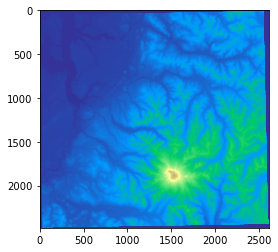

In [14]:
srtm_utm, srtm_utm_info = readTiff(path_srtm_utm)
print(srtm_utm_info)
plt.imshow(srtm_utm,vmin=0, vmax=7000, cmap='terrain')


In [17]:
# re-projected the l1a VNIR bands to utm (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_data/aster_parse/run-Band3N.tif $dir_data/aster_parse/run-Band3N.xml $dir_data/aster_reproj/VNIR-Band3N_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_data/aster_parse/run-Band3B.tif $dir_data/aster_parse/run-Band3B.xml $dir_data/aster_reproj/VNIR-Band3B_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_raw_aster/*VNIR_Band1*.tif $dir_data/aster_parse/run-Band3N.xml $dir_data/aster_reproj/VNIR-Band1_utm.tif
!mapproject -t rpc --tr 15 --t_srs "$tsrs_utm" $path_srtm_utm $dir_raw_aster/*VNIR_Band2*.tif $dir_data/aster_parse/run-Band3N.xml $dir_data/aster_reproj/VNIR-Band2_utm.tif



mapproject_single --query-projection data/aster_data/demo/srtm_dem_utm.tif data/aster_data/demo/aster_parse/run-Band3N.tif data/aster_data/demo/aster_parse/run-Band3N.xml data/aster_data/demo/aster_reproj/VNIR-Band3N_utm.tif -t rpc --tr 15 --t_srs +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
	--> Setting number of processing threads to: 4
Using session: rpc.
Loading camera model: data/aster_data/demo/aster_parse/run-Band3N.tif data/aster_data/demo/aster_parse/run-Band3N.xml
Output pixel size: 15
Projected space bounding box: (Origin: (549135, 5.17242e+06) width: 76500 height: 72615)
Image box: (Origin: (0, 0) width: 5101 height: 4842)
Output image size:
(width: 5101 height: 4842)
Query finished, exiting mapproject tool.

Output image size is 5101 by 4842 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /Users/luo/Library/CloudStorage/OneDrive-Personal/GitHub/Glacier-in-RGI1305 -u --env PATH --env PYTHONPATH --env ISISROOT --env ISISDATA -a data/aste

### 4. generate point cloud data

In [18]:
path_srtm_utm = 'data/aster_data/demo/srtm_dem_utm.tif'

!parallel_stereo -t astermaprpc -s $setting  --skip-rough-homography \
                      $dir_data/aster_reproj/VNIR-Band3N_utm.tif $dir_data/aster_reproj/VNIR-Band3B_utm.tif \
                      $dir_data/aster_parse/run-Band3N.xml $dir_data/aster_parse/run-Band3B.xml \
                      $dir_data/pc_utm_out/run $path_srtm_utm


Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 0 pixels.

[ 2022-Apr-02 21:58:26 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 4
Using stereo file script/stereo.default.
Writing log info to: data/aster_data/demo/pc_utm_out/run-log-stereo_pprc-04-02-2158-16216.txt
Using session: astermaprpc.
Loading camera model: data/aster_data/demo/aster_reproj/VNIR-Band3N_utm.tif data/aster_data/demo/aster_parse/run-Band3N.xml
Loading camera model: data/aster_data/demo/aster_reproj/VNIR-Band3B_utm.tif data/aster_data/demo/aster_parse/run-Band3B.xml
Distance between camera centers in meters: 410534.
Using image files:  data/aster_data/demo/aster_reproj/VNIR-Band3N_utm.tif, data/aster_data/demo/aster_reproj/VNIR-Band3B_utm.tif
Using camera files: data/aster_data/demo/aster_parse/run-Band3N.xml, data/aster_data/demo/aster_parse/run-Band3B.xml
Using input DEM: data/aster_data/demo/srtm_dem_utm.tif
Computing statistics f

### convert point cloud data to dem

In [38]:
# !point2dem --tr 0.000277777777778 --errorimage $dir_out/pc_wgs84_out/run-PC.tif -o $dir_out/dem_wgs84_out/run
!point2dem --tr $output_res --t_srs "$tsrs_utm" --errorimage $dir_data/pc_utm_out/run-PC.tif -o $dir_data/dem_utm_out/run



	--> Setting number of processing threads to: 4
Writing log info to: data/aster_data/demo/dem_utm_out/run-log-point2dem-04-02-2225-18960.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Automatic triangulation error cutoff is 91.5336 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2435,2366) px.
Writing: data/aster_data/demo/dem_utm_out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.722036
Writing: data/aster_data/demo/dem_utm_out/run-IntersectionErr.tif
IntersectionErr: [***************************************************] Complete!


### Visualize results.

In [21]:
### layer stacking for VNIR bands.
Band1 = dir_data + '/aster_reproj/VNIR-Band1_utm.tif'
Band2 = dir_data + '/aster_reproj/VNIR-Band2_utm.tif' 
Band3N = dir_data + '/aster_reproj/VNIR-Band3N_utm.tif' 
path_laysta = dir_data + '/aster_reproj/VNIR_LayStack_utm.tif'
lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laysta, union=True)



Images layer stacking done.


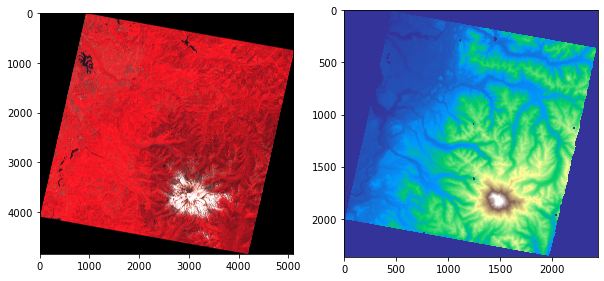

In [22]:
path_laysta_utm = dir_data + '/aster_reproj/VNIR_LayStack_utm.tif'
path_dem_aster_utm = dir_data + '/dem_utm_out/run-DEM.tif'
dem_aster_utm, dem_aster_utm_info = readTiff(path_dem_aster_utm)
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=5)
plt.subplot(1,2,2); 
plt.imshow(dem_aster_utm, vmin=0, vmax=4000, cmap='terrain')


In [36]:
path_dems = dir_data + '/dems_utm_stack.tif'
lay_stack(path_imgs=[path_srtm_utm, path_dem_aster_utm], path_out=path_dems)
dems_utm, dems_utm_info = readTiff(path_dems)
dems_dif = dems_utm[:,:,0]-dems_utm[:,:,1]


Images layer stacking done.


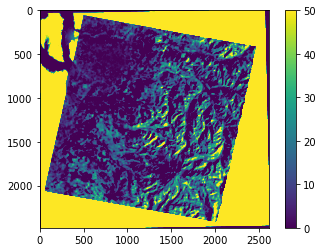

In [37]:
plt.imshow(dems_dif, vmin=0, vmax=50)
plt.colorbar()
